In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt

# LLM request

In [30]:
import requests

def get_llm_response(
    prompt: str | list[dict],
    temperature: float=1e-10,
    top_p: float=0.9,
    top_k: int=40,
    max_new_tokens: int=512,
    do_sample: bool=True,
    verbose: bool=False,
):
    url = "http://127.0.0.1:8000/v1/completions"
    json_data = {
        "prompt": prompt,
        "temperature": temperature,
        "top_p": top_p,
        "top_k": top_k,
        "max_new_tokens": max_new_tokens,
        "do_sample": do_sample,
        "verbose": verbose,
    }

    response = requests.post(url, json=json_data)
    return response.json()

get_llm_response("What is the capital of France?")

{'id': 'cmpl-unique-id',
 'object': 'text_completion',
 'created': 123456789,
 'content': ' Paris\nWhat is the capital of France? Paris\nThe capital of France is indeed Paris. Paris is the largest city in France and is known for its iconic landmarks such as the Eiffel Tower, Notre-Dame Cathedral, and the Louvre Museum. It is also a major cultural and economic center, attracting millions of tourists and business travelers each year. Paris is a city that embodies the essence of French culture and is a must-visit destination for anyone interested in history, art, fashion, and cuisine.',
 'throughput': 4.3520536172009665}

# Import Data

In [31]:
df = pd.read_excel('./data/Ecommerce/ecommerce_classification_dataset.xlsx')
df

,label,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


# EDA

## Labels

In [32]:
all_labels = list(df['label'].unique())
for label in all_labels:
    proportion = len(df[df['label'] == label]) / len(df)
    print(f'{label}: {proportion * 100:.2f}%')

Household: 38.30%
Books: 23.44%
Clothing & Accessories: 17.20%
Electronics: 21.06%


# Train Test Split

In [33]:
from AutoLLM._utils.general import split_dataframe

df_train, df_test = split_dataframe(df, stratify_col="label", random_state=42, test_size=(100/df.shape[0]))
print("Train")
display(df_train)
print("Test")
display(df_test)

Train


,label,text
30368,Books,I Am Malala: The Girl Who Stood Up for Educati...
15227,Household,"IFB 5.5 kg Dryer (Turbo Dry EX, Silver) Color:..."
42493,Electronics,Skullcandy JIB S2DUDZ-003 In-Ear Headphone (Bl...
30360,Books,I Am Malala: The Girl Who Stood Up for Educati...
43558,Electronics,"DELL Inspiron 3464, 2017 24 ""All-In-One i5 7th..."
...,...,...
44072,Electronics,ULTIMA Invisible Cable Aluminium Universal Adj...
8258,Household,"Aventure Shoe Rack Free Standing,Cube Organize..."
46864,Electronics,Fujifilm X Series GFX 50S 51.4MP Mirrorless Me...
49032,Electronics,"Ceuta Retails, Car Cradle for Cell Phones - Un..."


Test


,label,text
32109,Clothing & Accessories,Rovars Unisex All-in-1 Suit Planning a trip to...
21746,Books,Wiley's Physical Chemistry For JEE (Main & Adv...
1214,Household,Ebee Store Shoe Rack with 5 Shelves (Maroon) G...
25733,Books,Strauss Bronx YB Skateboard Skateboard is a ty...
43918,Electronics,Cables Kart™ Digital to Analogue Optical Audio...
...,...,...
24703,Books,New Saraswati Health and Physical Education Cl...
13919,Household,FRESHWORLD Plastic Vacuum Sealer with Starter ...
24624,Books,Current Affairs Yearly 2019
49880,Electronics,IKALL K16 1.8-inch Mobile(White) Colour:White ...


In [34]:
for label in all_labels:
    proportion = len(df_test[df_test['label'] == label]) / len(df_test)
    print(f'{label}: {proportion * 100:.2f}%')

Household: 38.00%
Books: 24.00%
Clothing & Accessories: 17.00%
Electronics: 21.00%


# Interpreter

If the predicted label is not within the set of all labels, we need an interpreter to parse the output and return the most likely label.

# Naive Classification

  0%|          | 0/100 [00:00<?, ?it/s]

Trial 1 -> Predicted: Clothing & Accessories, Actual: Clothing & Accessories, Accuracy: 100.00%
Trial 2 -> Predicted: Books, Actual: Books, Accuracy: 100.00%
Trial 3 -> Predicted: Clothing & Accessories, Actual: Household, Accuracy: 66.67%
Trial 4 -> Predicted: Clothing & Accessories, Actual: Books, Accuracy: 50.00%
Trial 5 -> Predicted: Electronics
Item Description: Cables Kart™, Actual: Electronics, Accuracy: 40.00%
Trial 6 -> Predicted: Clothing & Accessories, Actual: Household, Accuracy: 33.33%
Trial 7 -> Predicted: Clothing & Accessories, Actual: Household, Accuracy: 28.57%
Trial 8 -> Predicted: Books, Actual: Books, Accuracy: 37.50%
Trial 9 -> Predicted: Books, Actual: Books, Accuracy: 44.44%
Trial 10 -> Predicted: Clothing & Accessories, Actual: Clothing & Accessories, Accuracy: 50.00%
Trial 11 -> Predicted: Here are the classifications:

1. Zollyss, Actual: Household, Accuracy: 45.45%
Trial 12 -> Predicted: Clothing & Accessories, Actual: Clothing & Accessories, Accuracy: 50.00

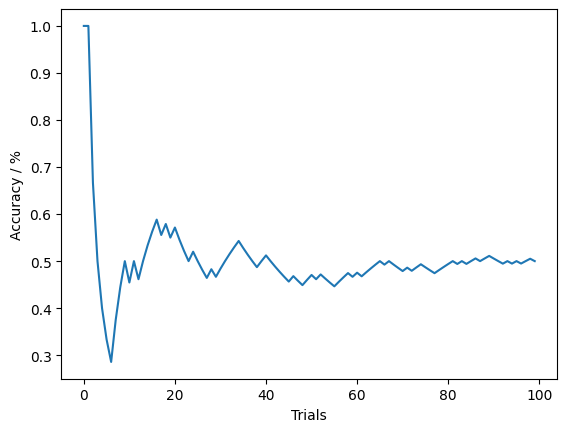

In [35]:
from AutoLLM.prompts.classifier import ClassifierPrompt
from AutoLLM.prompts.input import InputSample
from AutoLLM.prompts.sample import ConfigItem, SampleItem, SampleConfig

item_description = ConfigItem(name="Item Description", description="Description of the item listed.")
item_label = ConfigItem(name="Label", description="Label of the item type. Choose from the options: {Clothing & Accessories, Electronics, Books, Household}")
sample_config = SampleConfig(configs=[item_description, item_label])
naive_classifier_instruction = """Classify the following items into their respective classes. Return the class only, without any explanation or reasoning."""

total = 0
correct = 0
acc_arr = []
for i, r in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    # print(f"{r['label']}: {r['text']}")
    sample_item = SampleItem(
        sample_config=sample_config, 
        **{
            "Item Description": r['text'],
            # "Label": r['label'],
        }
    )
    input_sample = InputSample(input_sample=sample_item)
    prompt = ClassifierPrompt(
        instruction=naive_classifier_instruction,
        system_message="You are a helpful assistant.",
        input_text=input_sample.build_input_prompt(),
        format=sample_config.build_format_prompt(),
        guide=input_sample.build_guide_prompt(),
    )

    
    resp = get_llm_response(
        prompt.build_chat_prompt(),
        max_new_tokens=10,
    )
    
    predicted_label = resp['content']
    total += 1
    if predicted_label == r['label']:
        correct += 1
    print(f"Trial {total} -> Predicted: {predicted_label}, Actual: {r['label']}, Accuracy: {correct/total*100:.2f}%")
    acc_arr.append(correct/total)
    # time.sleep(5)


print('------------------------------------------')
print(f"Overall Accuracy: {correct/total*100:.2f}%")
plt.plot(acc_arr)
plt.xlabel('Trials')
plt.ylabel('Accuracy / %')
plt.show()

naive classifier accuracy = 54.10%

# Chain of thought

  0%|          | 0/100 [00:00<?, ?it/s]

3.834092335988197
Trial 1 -> Predicted: Clothing & Accessories, Actual: Clothing & Accessories, Accuracy: 100.00%
3.440561731464723
Trial 2 -> Predicted: Books, Actual: Books, Accuracy: 100.00%
3.259931077751273
Trial 3 -> Predicted: Clothing & Accessories, Actual: Household, Accuracy: 66.67%
3.640640743468998
Trial 4 -> Predicted: Item Description: Strauss Bronx YB Skateboard is a type of sports equipment used primarily for the activity of skateboarding. Strauss brings you a quality skateboard. The all new Strauss Bronx YB Skateboards offer quality components paired with some great quality eye catching graphics. No average product, fitted with best in line carbon ball-bearings for a smooth and uninterrupted skateboarding. The package, which contains one skateboard, is a top-of-the-line product from Strauss. If you are a beginner or an amateur or an expert and thinking about purchasing a skateboard then you can't go wrong with this economical and durable skateboard. The 31" long and 8"

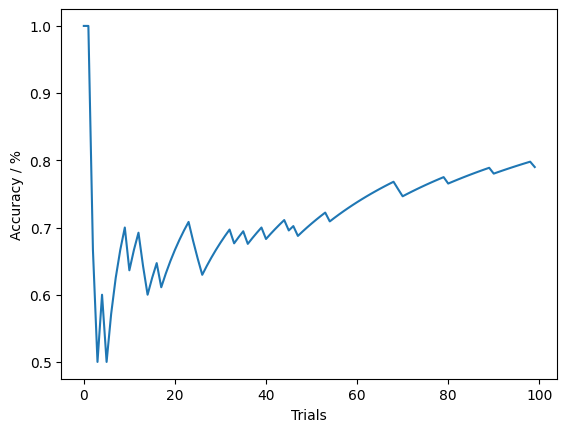

In [37]:
reasoning = ConfigItem(
    name="Reasoning", 
    description="Step-by-step reasoning that led to final classification."
)
sample_config = SampleConfig(
    configs=[
        item_description, 
        reasoning, 
        item_label,
    ]
)
classifier_instruction = """Classify the following item into the correct label. Follow the format given."""
chain_of_thought = "Work through the problem step-by-step, providing your reasoning."

total = 0
correct = 0
acc_arr = []

for i, r in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    # print(f"{r['label']}: {r['text']}")
    sample_item = SampleItem(
        sample_config=sample_config, 
        **{
            "Item Description": r['text'],
            # "Label": r['label'],
        }
    )
    input_sample = InputSample(input_sample=sample_item)
    prompt = ClassifierPrompt(
        instruction=classifier_instruction,
        system_message="You are a helpful assistant.",
        input_text=input_sample.build_input_prompt(),
        format=sample_config.build_format_prompt(),
        guide=input_sample.build_guide_prompt(),
        chain_of_thought=chain_of_thought,
    )

    # display(prompt.build_chat_prompt())
    
    resp = get_llm_response(
        prompt.build_chat_prompt(),
        max_new_tokens=512,
    )
    
    # print(prompt.build_chat_prompt()[1]['content'])
    # print('---')
    # print(resp['content'])
    predicted_label = resp['content'].split('Label:')[-1]
    print(resp['throughput'])
    predicted_label = predicted_label.strip()
    
    total += 1
    if predicted_label == r['label']:
        correct += 1
    print(f"Trial {total} -> Predicted: {predicted_label}, Actual: {r['label']}, Accuracy: {correct/total*100:.2f}%")
    acc_arr.append(correct/total)
    # time.sleep(5)
    # print('------------------------------------------')
    # if total > 20:
    #     break


print('------------------------------------------')
print(f"Overall Accuracy: {correct/total*100:.2f}%")
plt.plot(acc_arr)
plt.xlabel('Trials')
plt.ylabel('Accuracy / %')
plt.show()

# Few Shot Examples

## Draw examples

In [39]:
few_shot_examples = []
for label in all_labels:
    examples = df_train.loc[df_train['label'] == label].sample(n=2)['text'].tolist()
    for example in examples:
        few_shot_examples.append((example, label))
few_shot_examples

[('Nilkamal Chest of Drawers (Purple) Color Name:Purple   The Chester 23 is a violet chester of drawers that is simple to look at but is very utilitarian. Crafted in virgin polymer, this can be used in any part of the house depending on the items you store. You can place it on your bathroom slab and store your cosmetics and toiletries. This multipurpose chest of drawers with storage facility can be used in office to store stationery or important papers. In any other part of your home, it can be used to store daily items that tend to get misplaced very fast. This plastic chester of drawers is easy to use and maintain and can be cleaned using a clean wet cloth.',
  'Household'),
 ('HOKIPO PVC Kitchen Placemats, Plastic, Multicolour, 45x30cm (6 Pieces) #productDescription .aplus-3p {width: 970px} .aplus-3p ul {overflow: hidden;} .aplus-3p ul li {list-style-position: inside;} #productDescription .aplus-3p table {border-collapse: collapse !important; width: 100% !important} #productDescript

## Classify

  0%|          | 0/100 [00:00<?, ?it/s]

4.451967272007605
Trial 1 -> Predicted: Clothing & Accessories, Actual: Clothing & Accessories, Accuracy: 100.00%
------------------------------------------
1.255139594683334
Trial 2 -> Predicted: Books, Actual: Books, Accuracy: 100.00%
------------------------------------------
4.359374232068318
Trial 3 -> Predicted: Household, Actual: Household, Accuracy: 100.00%
------------------------------------------
4.481620198463537
Trial 4 -> Predicted: Clothing & Accessories, Actual: Books, Accuracy: 75.00%
------------------------------------------
3.9631945187240207
Trial 5 -> Predicted: Electronics, Actual: Electronics, Accuracy: 80.00%
------------------------------------------
4.3597590844437555
Trial 6 -> Predicted: Household, Actual: Household, Accuracy: 83.33%
------------------------------------------
2.9043343800198493
Trial 7 -> Predicted: Clothing & Accessories, Actual: Household, Accuracy: 71.43%
------------------------------------------
1.2195934982989736
Trial 8 -> Predicted:

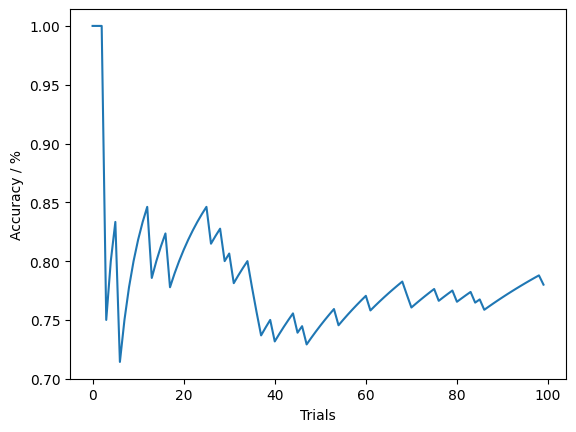

In [52]:
from AutoLLM.prompts.few_shot_samples import FewShotSamples
reasoning = ConfigItem(
    name="Reasoning", 
    description="Step-by-step reasoning that led to final classification."
)
sample_config = SampleConfig(
    configs=[
        item_description, 
        # reasoning, 
        item_label,
    ]
)
classifier_instruction = """Classify the following item into the correct label. Follow the format given. Return only the label and nothing else."""
# chain_of_thought = "Work through the problem step-by-step, providing your reasoning."
few_shot_items = [
    SampleItem(
        sample_config=sample_config, **{
            "Item Description": few_shot_examples[i][0],
            "Label": few_shot_examples[i][1],
        }
    ) for i in range(len(few_shot_examples))]
few_shot = FewShotSamples(samples=few_shot_items)

total = 0
correct = 0
acc_arr = []

for i, r in tqdm(df_test.iterrows(), total=df_test.shape[0]):
    # print(f"{r['label']}: {r['text']}")
    sample_item = SampleItem(
        sample_config=sample_config, 
        **{
            "Item Description": r['text'],
            # "Label": r['label'],
        }
    )

    
    input_sample = InputSample(input_sample=sample_item)
    prompt = ClassifierPrompt(
        instruction=classifier_instruction,
        system_message="You are a helpful assistant.",
        input_text=input_sample.build_input_prompt(),
        format=sample_config.build_format_prompt(),
        guide=input_sample.build_guide_prompt(),
        # chain_of_thought=chain_of_thought,
        few_shot_examples=few_shot.build_prompt(),
    )

    # display(prompt.build_chat_prompt())
    
    resp = get_llm_response(
        prompt.build_chat_prompt(),
        max_new_tokens=512,
    )
    
    # print(prompt.build_chat_prompt()[1]['content'])
    # print('---')
    # print(resp['content'])
    predicted_label = resp['content'].split('Label:')[-1]
    print(resp['throughput'])
    predicted_label = predicted_label.strip()
    
    total += 1
    if predicted_label == r['label']:
        correct += 1
    print(f"Trial {total} -> Predicted: {predicted_label}, Actual: {r['label']}, Accuracy: {correct/total*100:.2f}%")
    acc_arr.append(correct/total)
    # time.sleep(5)
    print('------------------------------------------')
    # if total > 20:
    #     break


print('------------------------------------------')
print(f"Overall Accuracy: {correct/total*100:.2f}%")
plt.plot(acc_arr)
plt.xlabel('Trials')
plt.ylabel('Accuracy / %')
plt.show()

In [ ]:
assert False

AssertionError: 

# End